In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy import signal
from math import exp
import processes.foundation as fd
from math import exp, sqrt, pi, erfc
from lmfit import Model
import csv
from scipy.optimize import curve_fit
import pywt
from statistics import median
import copy
from matplotlib import colors

In [41]:
def sigPulseSpecific(riseMax, riseMin, Energy):
    rise = int((riseMax-riseMin)*np.random.random()+riseMin)
    energy = Energy



    pulse = np.zeros(15000)
    x = np.linspace(-rise-40,rise+40,2*rise+81)
    y = energy/(1 + np.exp(-x/(0.3*rise)))

    pulse[10000: 10000+len(x)] = y
    pulse[10000+len(x)::] = y[-1]


    return pulse

In [42]:
def get_trap_max(wp):
    w_trap = np.zeros(len(wp))

    rise = int(6/.008)
    flat = int(0.8/.008)

    w_trap[0] = wp[0]/rise
    for i in range(1, rise, 1):
        w_trap[i] = w_trap[i - 1] + wp[i] / rise
    for i in range(rise, rise + flat, 1):
        w_trap[i] = w_trap[i - 1] + (wp[i] - wp[i - rise])/rise
    for i in range(rise + flat, 2 * rise + flat, 1):
        w_trap[i] = w_trap[i - 1] + (wp[i] - wp[i - rise] - wp[i - rise - flat])/rise
    for i in range(2 * rise + flat, len(wp), 1):
        w_trap[i] = (
        w_trap[i - 1]
        + (wp[i]
        - wp[i - rise]
        - wp[i - rise - flat]
        + wp[i - 2 * rise - flat])/rise
    )

    return np.max(w_trap)

In [43]:
#Here is Method 2 which calculates the rise time by using a starting index and going left till it finds a threshold.
#Method 1 also uses an RNG sigmoid pulsar.
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
wave = data[0]["waveform"]["values"].nda[1]

energy_Step = 10000
energy_lis = np.linspace(0,125,energy_Step)
trapEmax = np.zeros(energy_Step)
wfEmax = np.zeros(energy_Step)
#correct = np.zeros(nb)
#false = np.zeros(nb)

cDs = pywt.swt(wave, "haar", level=4)
threshold = np.zeros_like([0,0,0,0])

j=0
for cD in cDs:
    median_value = median(cD[1])
    median_average_deviation = median([abs(number-median_value) for number in cD[1]])
    sig1 = median_average_deviation/0.6745
    threshold[j] = sig1*np.sqrt(2*np.log(len(wave)))
    j+=1

j=0
for cD in cDs:
    cD[1][abs(cD[1]) < threshold[j]] = 0.0
    j += 1

wave = pywt.iswt(cDs, "Haar")

mean = np.nan
stdev = np.nan
slope = np.nan
intercept = np.nan


sum_x = sum_x2 = sum_xy = sum_y = mean = stdev = 0
isum = 15000

for i in range(0, 15000, 1):
    # the mean and standard deviation
        temp = wave[i] - mean
        mean += temp / (i + 1)
        stdev += temp * (wave[i] - mean)

        # linear regression
        sum_x += i
        sum_x2 += i * i
        sum_xy += wave[i] * i
        sum_y += wave[i]

slope = (isum * sum_xy - sum_x * sum_y) / (isum * sum_x2 - sum_x * sum_x)
intercept = (sum_y - sum_x * slope) / isum

line = np.array([x * slope + intercept for x in range(0, len(wave))])
wave = wave - line


for i,energy in enumerate(energy_lis):

    pulse = sigPulseSpecific(70,50,energy)
    wave1 = copy.deepcopy(wave)
    wp = wave1[0:15000] + pulse
    trapEmax[i] = get_trap_max(wp)
    wfEmax[i] = np.max(wp)

In [46]:
trapEnergy = trapEmax*0.0408625 -0.16892
realEnergy = energy_lis*0.0408625 -0.16892
deltaE = abs(trapEnergy - realEnergy)

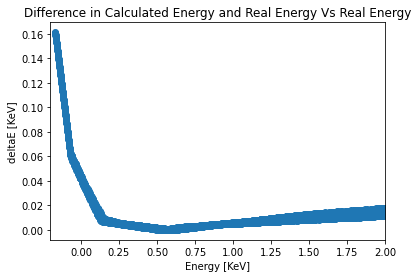

In [53]:
plt.scatter(realEnergy, deltaE)
plt.xlim(-0.2,2)
plt.xlabel("Energy [KeV]")
plt.ylabel("deltaE [KeV]")
plt.title("Difference in Calculated Energy and Real Energy Vs Real Energy")
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.savefig("images/deltaEVsE.pdf", facecolor = "white")
plt.show()

In [8]:
df = fd.get_df("9188", "Card1")

In [18]:
df = df.drop_duplicates("timestamp")

In [19]:
df

,channel,timestamp,startEnergy,maxEnergy,trapEmax,tp_max,wfEmax,tp_50
0,0,34259632908387,134317535,27,6132.491699,152432.0,8084.515625,152432.0
1,0,34259633488287,134316413,4,4543.745605,138184.0,4595.859863,138184.0
3,0,34252175986278,134314664,4294967271,3940.395264,138176.0,4011.244141,138176.0
4,0,34252176131639,134315508,4294967250,4032.402100,138168.0,4079.388672,138168.0
6,0,34259634540652,134315657,12,4260.308594,138152.0,4337.847656,138152.0
...,...,...,...,...,...,...,...,...
8350,0,34260881218773,134314526,4294967246,8352.347656,138320.0,8416.989258,138320.0
8351,0,34260881681040,134313543,4294967260,1769.154053,130976.0,13242.864258,130976.0
8356,0,34260882475609,134315612,11,4053.804688,138200.0,4098.577637,138200.0
8361,0,34260883265856,134317492,32,1716.297241,137880.0,1763.447998,137880.0


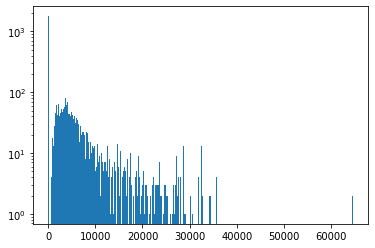

In [10]:
plt.hist(df["trapEmax"], bins=1000)
plt.yscale("log")
plt.show()

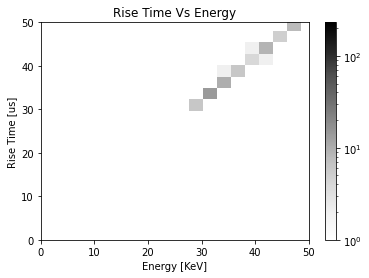

In [29]:
plt.hist2d(df["trapEmax"]*0.0408625 -0.16892, df["wfEmax"]*0.0408625 -0.16892, bins=(1000,1000),norm = colors.LogNorm(), cmap=plt.cm.Greys)
plt.colorbar()
plt.xlim(0,50)
plt.ylim(0,50)
plt.xlabel("Energy [KeV]")
plt.ylabel("Rise Time [us]")
plt.title("Rise Time Vs Energy")
#plt.rcParams['savefig.facecolor']='white'
#plt.rcParams['axes.facecolor']='white'
#plt.savefig("images/riseTimeVsEnergyLogFine.pdf", facecolor = "white")
plt.show()

In [30]:
df["energyDiff"] = abs(df["wfEmax"] - df["trapEmax"])

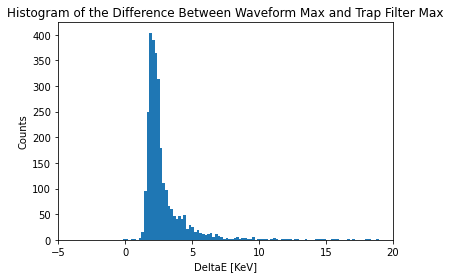

In [38]:
plt.hist(df["energyDiff"]*0.0408625 -0.16892, bins=10000)
plt.xlim(-5,20)
plt.xlabel("DeltaE [KeV]")
plt.ylabel("Counts")
plt.title("Histogram of the Difference Between Waveform Max and Trap Filter Max")
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.savefig("images/DifferenceBetweenWaveAndMax.pdf", facecolor = "white")
plt.show()